# BinaryNet Patch Camelyon


Implementation of [BinaryNet](https://arxiv.org/abs/1602.02830) on the Patch Camelyon medical dataset

In [50]:
import tensorflow as tf
import larq as lq
import tensorflow_datasets as tfds
from typing import Tuple

We load the Patch Camelyon dataset with tensorflow_datasets, which helpfully fetches, loads, and lets us access the data with an optimised TensorFlow dataset pipeline.

In [68]:
data, info = tfds.load('patch_camelyon', with_info=True, as_supervised=True)

W0710 12:10:01.977504 4662900160 dataset_builder.py:384] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


The Patch Camelyon dataset has predefined splits for training, validation, and testing.

In [69]:
train_data, val_data, test_data = data['train'], data['validation'], data['test']

In [70]:
train_data = train_data.shuffle(
    buffer_size=info.splits['train'].num_examples, 
    reshuffle_each_iteration=True
)

## Gather Metadata

In [71]:
shape = info.features['image'].shape
num_classes = info.features['label'].num_classes

In [72]:
train_batch_size = 32
val_batch_size = 64

In [73]:
train_data = train_data.batch(32)

In [74]:
train_data = train_data.prefetch(2)

## Model

In [78]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(96, 96, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("sigmoid")
])

In [79]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d_36 (QuantConv2D (None, 94, 94, 128)       6914      
_________________________________________________________________
batch_normalization_54 (Batc (None, 94, 94, 128)       384       
_________________________________________________________________
quant_conv2d_37 (QuantConv2D (None, 94, 94, 128)       294914    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 47, 47, 128)       0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 47, 47, 128)       384       
_________________________________________________________________
quant_conv2d_38 (QuantConv2D (None, 47, 47, 256)       589826    
_________________________________________________________________
batch_normalization_56 (Batc (None, 47, 47, 256)      

In [80]:
larq.models.summary(model)

+sequential_4 stats-------------------------------------------------------------------+
| Layer                   Input prec.            Outputs   # 1-bit  # 32-bit   Memory |
|                               (bit)                                            (kB) |
+-------------------------------------------------------------------------------------+
| quant_conv2d_36                   -  (-1, 94, 94, 128)      3456         0     0.42 |
| batch_normalization_54            -  (-1, 94, 94, 128)         0       384     1.50 |
| quant_conv2d_37                   1  (-1, 94, 94, 128)    147456         0    18.00 |
| max_pooling2d_18                  -  (-1, 47, 47, 128)         0         0     0.00 |
| batch_normalization_55            -  (-1, 47, 47, 128)         0       384     1.50 |
| quant_conv2d_38                   1  (-1, 47, 47, 256)    294912         0    36.00 |
| batch_normalization_56            -  (-1, 47, 47, 256)         0       768     3.00 |
| quant_conv2d_39               

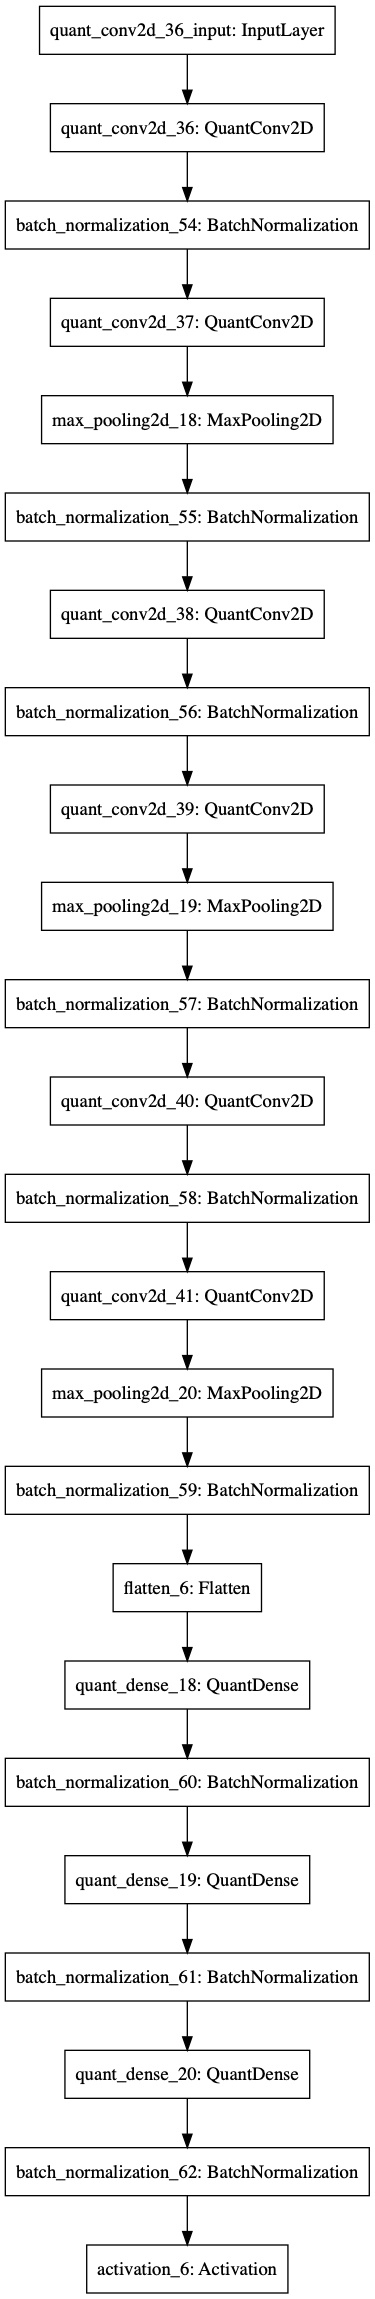

In [81]:
tf.keras.utils.plot_model(model, expand_nested=True)

In [82]:
model.compile(
    optimizer = larq.optimizers.Bop(fp_optimizer=tf.keras.optimizers.Adam(0.01)),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
trained_model = model.fit(
    x=train_data,
    epochs=10,
    validation_data=val_data,
    verbose=1
)

Epoch 1/10


W0710 12:11:24.039602 4662900160 deprecation.py:323] From /anaconda3/envs/TensorFlow-2.0/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


      3/Unknown - 87s 29s/step - loss: 0.8922 - accuracy: 0.4271 - quant_conv2d_36/flip_ratio: 0.0883 - quant_conv2d_37/flip_ratio: 3.7283e-05 - quant_conv2d_38/flip_ratio: 0.0000e+00 - quant_conv2d_39/flip_ratio: 0.0000e+00 - quant_conv2d_40/flip_ratio: 0.0000e+00 - quant_conv2d_41/flip_ratio: 0.0000e+00 - quant_dense_18/flip_ratio: 5.9605e-08 - quant_dense_19/flip_ratio: 0.0000e+00 - quant_dense_20/flip_ratio: 0.2090        